**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
# import matplotlib
# matplotlib.rcParams["image.interpolation"] = None
# import matplotlib.pyplot as plt
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

# from stardist import random_label_cmap
from stardist.models import StarDist3D

np.random.seed(6)
# lbl_cmap = random_label_cmap()

import zarr
import napari

from cupyx.scipy import ndimage
import cupy as cp

In [2]:
#moved_path = '/mnt/ampa_data01/tmurakami/220310_0004_R01/R03_R01/R03ch640_to_R01.zarr'
moved_path = '/mnt/ampa_data01/tmurakami/220310_0004_R01/ch785.zarr'
#moved_path = '/mnt/ampa_data01/tmurakami/220321_0004_R02/ch561.zarr'
#moved_path = '/mnt/ampa_data01/tmurakami/220329_0004_R03/ch640.zarr'

img_raw = zarr.open(moved_path)['0']
window_size = 256
z_start = 401#878#
y_start = 2904#2424#
x_start = 1860#5936#
img_raw = img_raw[z_start:z_start+window_size,y_start:y_start+window_size,x_start:x_start+window_size]

# n_channel = 1 # if X[0].ndim == 3 else X[0].shape[-1]
# axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
# if n_channel > 1:
#     print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

# img = normalize(img_raw, 1,99.8, axis=axis_norm)

# GPU percentile normalization
footprint=np.ones((1,5,100))
img_raw_cp = cp.asarray(img_raw)
img_high = ndimage.percentile_filter(img_raw_cp,99,footprint=footprint)
img_low = ndimage.percentile_filter(img_raw_cp,1,footprint=footprint)
img = (img_raw.astype(float) - img_low.get()) / (img_high.get() - img_low.get())

In [3]:
### load trained model

model = StarDist3D(None, name='stardist', basedir='models_06')
# help(model.predict_instances)

FileNotFoundError: config file doesn't exist: /home/tmurakami/src/stardist_notebooks/models_06/stardist/config.json

In [13]:
%%time
# https://github.com/stardist/stardist/issues/36
# https://github.com/stardist/stardist/blob/0d9dffbb6b010e0802e0a1267b8fd60b7f6838cf/stardist/models/base.py#L432

labels, details = model.predict_instances(img, n_tiles=(2,2,2), show_tile_progress=True)
# labels, details = model.predict_instances_big(img,axes='ZYX',block_size=(256, 256, 256), min_overlap=48, context=64, show_progress=True)
# labels, details = model.predict_instances_big(img_raw,axes='ZYX',block_size=(1488, 1024, 1024), min_overlap=48, context=64, show_progress=True, n_tiles=(5,3,3))

  0%|                                                                                                                                            | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


 12%|████████████████▌                                                                                                                   | 1/8 [00:01<00:08,  1.18s/it]

1/1 [==============================] - 0s 56ms/step


 25%|█████████████████████████████████                                                                                                   | 2/8 [00:02<00:07,  1.18s/it]

1/1 [==============================] - 0s 55ms/step


 38%|█████████████████████████████████████████████████▌                                                                                  | 3/8 [00:03<00:05,  1.18s/it]

1/1 [==============================] - 0s 53ms/step


 50%|██████████████████████████████████████████████████████████████████                                                                  | 4/8 [00:04<00:04,  1.18s/it]

1/1 [==============================] - 0s 56ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████▌                                                 | 5/8 [00:05<00:03,  1.18s/it]

1/1 [==============================] - 0s 54ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████                                 | 6/8 [00:07<00:02,  1.18s/it]

1/1 [==============================] - 0s 56ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 7/8 [00:08<00:01,  1.18s/it]

1/1 [==============================] - 0s 57ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.18s/it]


CPU times: user 27min 9s, sys: 10.6 s, total: 27min 19s
Wall time: 37.7 s


In [5]:
viewer = napari.Viewer()
#viewer.add_image(img_raw, contrast_limits=[0, 15000], rgb=False, name='image01' , colormap='gray' ,blending='additive')
viewer.add_image(img_raw, rgb=False, name='image01' , colormap='gray' ,blending='additive')
viewer.add_image(img, rgb=False, name='image_norm' , colormap='gray' ,blending='additive')
viewer.add_labels(labels)

<Labels layer 'labels' at 0x7f7124780400>

In [5]:
# next round normalization based on cells
from skimage.measure import regionprops, regionprops_table
import pandas as pd
from scipy import interpolate
from scipy.spatial import Delaunay
from scipy.spatial import KDTree

In [6]:
# to boost interpolation
# https://stackoverflow.com/questions/20915502/speedup-scipy-griddata-for-multiple-interpolations-between-two-irregular-grids
# https://stackoverflow.com/questions/51858194/storing-the-weights-used-by-scipy-griddata-for-re-use/51937990#51937990

In [14]:
props = pd.DataFrame(regionprops_table(labels, intensity_image=img_raw, properties=('label','centroid','intensity_max')))
coords = props.loc[:,['centroid-0','centroid-1','centroid-2']].round().to_numpy().astype(int)
intensity_max = props.loc[:,['intensity_max']].to_numpy().flatten()

shape = img_raw.shape
edge_coords = np.asarray([
    [0,0,0],
    [shape[0]-1,0,0],
    [0,shape[1]-1,0],
    [0,0,shape[2]-1],
    [shape[0]-1,shape[1]-1,0],
    [shape[0]-1,0,shape[2]-1],
    [0,shape[1]-1,shape[2]-1],
    [shape[0]-1,shape[1]-1,shape[2]-1]
])
tree = KDTree(coords)
edge_intensity = intensity_max[tree.query(edge_coords)[1]]

coords = np.vstack([coords,edge_coords]) 
intensity_max = np.hstack([intensity_max,edge_intensity]) 

tri = Delaunay(coords)
interpolator = interpolate.LinearNDInterpolator(tri, intensity_max)

In [15]:
%%time
z = np.linspace(0, img_raw.shape[0]-1, img_raw.shape[0])
y = np.linspace(0, img_raw.shape[1]-1, img_raw.shape[1])
x = np.linspace(0, img_raw.shape[2]-1, img_raw.shape[2])
zg, yg ,xg = np.meshgrid(z, y, x, indexing='ij', sparse=True)
local_max = interpolator((zg,yg,xg))

img2 = (img_raw.astype(float) - img_low.get()) / (local_max - img_low.get())
img2[img2>2.0]=2.0
img2[img2<-1.0]=-1.0

CPU times: user 10.5 s, sys: 4.6 s, total: 15.1 s
Wall time: 9.55 s


In [16]:
%%time
#labels2, details2 = model.predict_instances(img2, show_tile_progress=True,return_predict=True)
labels2, details2 = model.predict_instances(img2, n_tiles=(2,2,2), show_tile_progress=True,return_predict=True)

base.py (680): Setting sparse to False because return_predict is True
  0%|                                                                                                                                            | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


 12%|████████████████▌                                                                                                                   | 1/8 [00:01<00:07,  1.09s/it]

1/1 [==============================] - 0s 56ms/step


 25%|█████████████████████████████████                                                                                                   | 2/8 [00:02<00:06,  1.07s/it]

1/1 [==============================] - 0s 55ms/step


 38%|█████████████████████████████████████████████████▌                                                                                  | 3/8 [00:03<00:05,  1.07s/it]

1/1 [==============================] - 0s 56ms/step


 50%|██████████████████████████████████████████████████████████████████                                                                  | 4/8 [00:04<00:04,  1.06s/it]

1/1 [==============================] - 0s 54ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████▌                                                 | 5/8 [00:05<00:03,  1.07s/it]

1/1 [==============================] - 0s 56ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████                                 | 6/8 [00:06<00:02,  1.07s/it]

1/1 [==============================] - 0s 55ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 7/8 [00:07<00:01,  1.06s/it]

1/1 [==============================] - 0s 55ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.06s/it]


CPU times: user 25min 4s, sys: 9.58 s, total: 25min 14s
Wall time: 35.6 s


In [9]:
from skimage.transform import rescale

In [19]:
viewer = napari.Viewer()
#viewer.add_image(img_raw, contrast_limits=[0, 15000], rgb=False, name='image01' , colormap='gray' ,blending='additive')
viewer.add_image(img_raw, rgb=False, name='image01' , colormap='gray' ,blending='additive')
viewer.add_image(img, rgb=False, name='image_norm' , colormap='gray' ,blending='additive')
viewer.add_image(img2, rgb=False, name='image_norm2' , colormap='gray' ,blending='additive')
viewer.add_labels(labels)
viewer.add_labels(labels2[0])
viewer.add_image(rescale(details2[0],2,preserve_range=True), rgb=False, name='prob' , colormap='gray' ,blending='additive')

<Image layer 'prob' at 0x7f34c5e73040>

In [44]:
save_tiff_imagej_compatible('/mnt/ampa_data01/tmurakami/conf_proc/whole_brain_seg/manual_check/R03_640.tif', img_raw, axes='ZYX')
save_tiff_imagej_compatible('/mnt/ampa_data01/tmurakami/conf_proc/whole_brain_seg/manual_check/R03_640_model04.tif', labels2, axes='ZYX')

__init__.py (40): Converting data type from 'int32' to ImageJ-compatible 'int16'.


In [19]:
save_tiff_imagej_compatible('/mnt/ampa_data01/tmurakami/conf_proc/whole_brain_seg/manual_check/R01_561_prob.tif', rescale(details2[0],2,preserve_range=True), axes='ZYX')

In [18]:
#

In [22]:
prob_ref = imread('/mnt/ampa_data01/tmurakami/conf_proc/whole_brain_seg/manual_check/R02_561_prob.tif')
prob = imread('/mnt/ampa_data01/tmurakami/conf_proc/whole_brain_seg/manual_check/R01_561_prob.tif')

In [43]:
props = pd.DataFrame(regionprops_table(labels2[0],intensity_image=prob_ref*prob,properties=('label','intensity_max','intensity_mean')))

In [36]:
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

-3.025661791172103


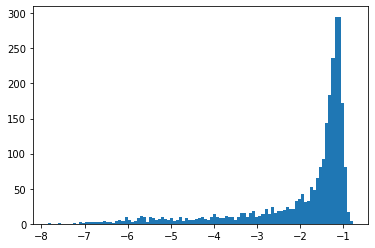

In [44]:
mean_joint_prob = props['intensity_mean'].to_numpy()
plt.hist(np.log10(mean_joint_prob),bins=100)
print(threshold_otsu(np.log10(mean_joint_prob)))
thresh = threshold_otsu(np.log10(mean_joint_prob))

In [50]:
filtered_ids = props['label'][np.log10(mean_joint_prob)>=bools].to_numpy()
filtered_labels = labels2[0] * np.isin(labels2[0],filtered_ids)

In [51]:
save_tiff_imagej_compatible('/mnt/ampa_data01/tmurakami/conf_proc/whole_brain_seg/manual_check/R01_561_model04_filtered.tif', filtered_labels, axes='ZYX')

__init__.py (40): Converting data type from 'int32' to ImageJ-compatible 'int16'.
